<img src="https://www.python.org/static/img/python-logo.png" width="300" alt="Python logo"  />
<font color='blue'>
$\Large\text{Pontificia Universidad Católica del Perú}$</font>

$$\Large \textit{Estadística Aplicada}$$

$$\large\textbf{Trabajo Clase 14: Regresión lineal multivariada}$$

Nombe alumno:
- ANA MUÑOZ MAQUERA
- CESAR BARRETO HERRERA
- JORDAN CAPA ZAMATA 


In [ ]:
# Librerias
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Leyendo el Dataframe y cambios antes de empezar el analisis

In [ ]:
df = pd.read_csv('/content/Student performance in mathematics.csv', index_col='Student ID')

# agreggo una nueva variable para tener un promedio de los scores
df['Final score'] = (df['Math score'] + df['Reading score'] + df['Writing score'])/3

# Transformando level of educacion de cualitativa discreta a ordinal

df['Parental level of education'].unique()

def education_to_ordinal(edu):
    if edu == "Some high school": return 1
    elif edu == "High school": return 2
    elif edu == "Some college": return 3
    elif edu == "Associate's degree": return 4
    elif edu == "Bachelor's degree": return 5
    elif edu == "Master's degree": return 6

# Aplicar la función al dataframe para crear la nueva columna
df['edu_numeric'] = df['Parental level of education'].map(education_to_ordinal)
df = df.drop('Parental level of education', axis = 1)

##### Como saber su el muestreo fue aleatorio



# 1. Explorando el dataset

## a) Problema a resolver

* El dataset contiene informacion del desempeno de los estudiantes de secundaria
* Incluye informacion demografica con la finalidad de analizar si estas variables influyen en el score final de los alumnos 
* No hay informacion si el muestreo fue aleatorio

In [ ]:
# El dataframe esta compuesto por
print('Total de filas', df.shape[0])
print('Total de columnas', df.shape[1])

Total de filas 207
Total de columnas 9


## b) Exploracion de variables

In [ ]:
# identifico variables cuantitativas y cualitativas
cualitativa = ['Gender', 'Race/ethnicity', 'Lunch', 'Test preparation course']
cuantitativa = ['edu_numeric', 'Math score', 'Reading score', 'Writing score', 'Final score']

### Cualitativas

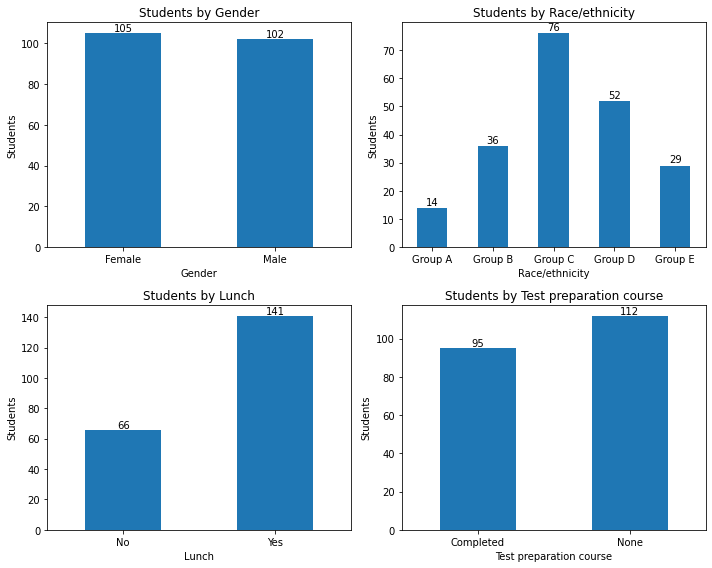

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))

# Iterar por cada variable cualitativa
for i, a in enumerate(cualitativa):
    # Calcular el índice de la fila y la columna correspondientes
    row = i // 2
    col = i % 2
    # Agrupar los datos por la variable cualitativa
    grupo = (df
            .groupby(by=a, as_index=False)
            .agg(n=('edu_numeric','count')))
    
    # Graficar el dataframe en el subplot correspondiente
    grupo.plot(kind='bar', x=a, y='n', legend=False, rot=0, ax=axs[row, col])
    # Añadir etiquetas a las barras
    for j, v in enumerate(grupo['n']):
        axs[row, col].text(j, v+1, str(v), ha='center', fontsize=10)
    # Añadir títulos y etiquetas de los ejes
    axs[row, col].set_title('Students by '+ a)
    axs[row, col].set_xlabel(a)
    axs[row, col].set_ylabel('Students')

# Ajustar el espaciado entre los subplots y mostrar el plot
plt.tight_layout()
plt.show()

* La relacion entre hombres y mujeres es equitativa
* Hay mayor cantidad de alumnos del grupo C de ethnicidad 
* Mayor cantidad de alumnos si recibe el Lunch gratuito
* Mas alumnos no completaron el test de preparacion

### Cuantitativas

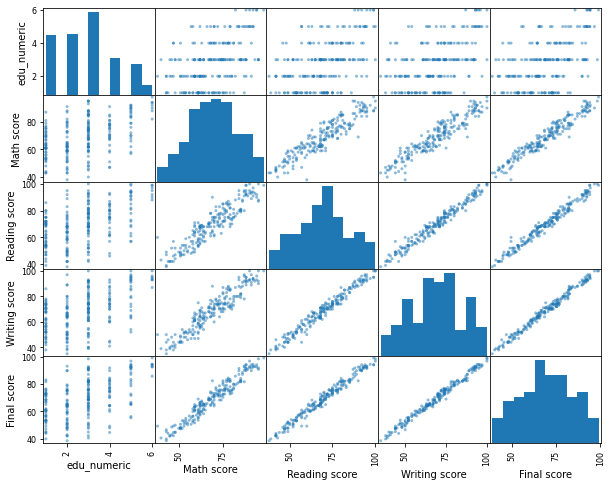

In [ ]:
# Dispercion de variables
pd.plotting.scatter_matrix(df[cuantitativa], figsize=(10, 8))
plt.show()

In [ ]:
# medidas de tendencia central
df.describe()

,Math score,Reading score,Writing score,Final score,edu_numeric
count,207.000000,207.000000,207.000000,207.000000,207.000000
mean,69.207729,69.898551,68.971014,69.359098,2.811594
std,13.528838,14.960607,15.843259,14.525927,1.385872
min,38.000000,38.000000,35.000000,38.666667,1.000000
25%,59.500000,59.000000,57.000000,59.166667,2.000000
50%,69.000000,70.000000,70.000000,69.333333,3.000000
75%,79.000000,80.000000,80.000000,79.833333,4.000000
max,98.000000,100.000000,100.000000,99.000000,6.000000


* El nivel educativo de los padres esta mas orientado en 3 (someschool), asi mismo el promedio es 2.8 con una desviacion estandar baja
* El puntaje obtenido en matematicas tiene una correlacion alta con final score y al parecer se distribuye de manera normal, el promedio del score es 69.2
* El reading score tambien tiene una correlacion con writing y math score, y al parecer tiene una distribucion normal con un promedio de 69.8
* El Writing score tambien muestra una correlacion con las otras notas, pero al parecer la distribucion no es normal y tiene un promedio de 68.9
* El Final score al estar basado en las otras 3 notas tambien tiene correlacion, pero se aprecia una correlacion mas fuerte con wrinting score, la distribucion de esta variable no parece ser normal. Ademas tiene un promedio de 69.3
* La desviacion estandar de las diferentes notas oscila ente 13 y 15

## c) Exploracion de dos variables

### Relacion entre variables

In [ ]:
# funcion para hallar la relacion enmtre variables con chi2
def contingencia(column1, column2):
  conting = pd.crosstab(df[column1], df[column2])
  chi2, pval, dof, expected = chi2_contingency(conting)
  table = pd.DataFrame(columns=['chi2', 'pval'], data=[[chi2,pval]])
  return print(table, column1)

# Probando la relacion de todas las variables con final score
for i in df.drop('Final score', axis=1).columns:
  contingencia(i, 'Final score')

        chi2      pval
0  123.71584  0.231027 Gender
         chi2      pval
0  425.175932  0.812771 Race/ethnicity
        chi2     pval
0  113.45295  0.47033 Lunch
         chi2      pval
0  130.081212  0.129791 Test preparation course
          chi2          pval
0  6668.604194  3.109782e-07 Math score
          chi2          pval
0  7675.550522  5.521062e-25 Reading score
        chi2          pval
0  7311.2975  8.772207e-11 Writing score
        chi2      pval
0  607.22677  0.106403 edu_numeric


* La relacion de variables con final escore estara basada en la 
Ho: Existe relacion significativa entre las variables
* El p value de las variables Math score, Reading score y Writing score son menores a 0.05 por lo que diriamos que existe una asociacion significativa entre esta variables
* Por otro lado las variables Gender, Race, lunch, test y edu_numeric NO tiene una asociacion significativa a Final score

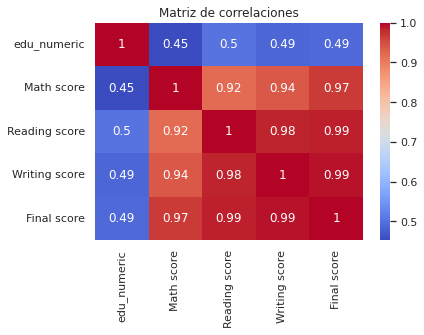

In [ ]:
# Correlaciones entre variables numericas
corr_matrix = df[cuantitativa].corr()
sns.set(style="white")
# Generar el heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
# Añadir título
plt.title("Matriz de correlaciones")

# Mostrar el gráfico
plt.show()

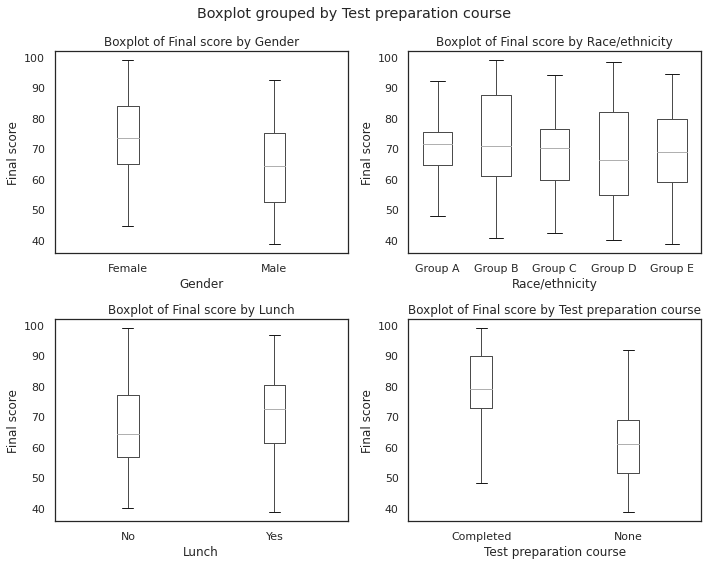

In [ ]:
# Relacion de target convariables categoricas

# Crear una figura con 2 filas y 3 columnas
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterar por cada variable cualitativa
for i, a in enumerate(cualitativa):
    # Calcular el índice de la fila y la columna correspondientes
    row = i // 2
    col = i % 2

    # Crear el boxplot en el subplot correspondiente
    df.boxplot(by=a, column='Final score', grid=False, rot=0, ax=axs[row, col])
    
    # Añadir etiquetas a los ejes y al título
    axs[row, col].set_xlabel(a)
    axs[row, col].set_ylabel('Final score')
    axs[row, col].set_title('Boxplot of Final score by ' + a)

# Ajustar el espaciado entre los subplots y mostrar el plot
plt.tight_layout()
plt.show()

* Las variables con mayor correlacion son las de math score, reading score, wrinting score y Final score. Estas tres primeras variables explican altamente a la ultima 
* El nivel educativo casi no muestra asociacion
* Existe bastante diferencia en el final score entre los alumnos que completaron el test preparation vs los que no. Lo mismo sucede con las variables de Lunch y Gender
* La relacion entre final score y el Race es minima, pues entre los grupos no se ve mucha diferencia

# 2. Modelos Probabilisticos

## a) Identificar variables con distribucion normal

### Distribucion de la variable

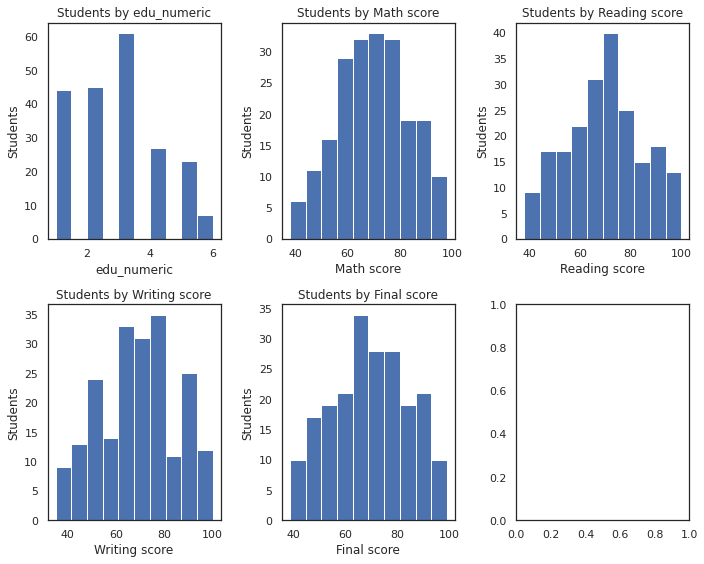

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

# Iterar por cada variable cualitativa
for i, a in enumerate(cuantitativa):
    # Calcular el índice de la fila y la columna correspondientes
    row = i // 3
    col = i % 3 
    axs[row, col].hist(df[a])
    # Añadir títulos y etiquetas de los ejes
    axs[row, col].set_title('Students by '+ a)
    axs[row, col].set_xlabel(a)
    axs[row, col].set_ylabel('Students')

# Ajustar el espaciado entre los subplots y mostrar el plot
plt.tight_layout()
plt.show()

### Analizar graficamente asimetria de la distribucion

((array([-2.71209841, -2.40375995, -2.2281239 , -2.10241334, -2.00314327,
         -1.92040516, -1.84904323, -1.78601765, -1.72937932, -1.67780047,
         -1.63033418, -1.5862804 , -1.54510633, -1.50639667, -1.46982113,
         -1.43511253, -1.40205152, -1.37045571, -1.34017173, -1.3110693 ,
         -1.28303681, -1.25597783, -1.22980847, -1.20445525, -1.17985348,
         -1.15594581, -1.1326812 , -1.11001402, -1.08790327, -1.06631197,
         -1.04520665, -1.02455692, -1.00433508, -0.98451582, -0.96507592,
         -0.94599406, -0.92725058, -0.90882734, -0.89070751, -0.87287552,
         -0.85531685, -0.838018  , -0.82096638, -0.80415018, -0.78755836,
         -0.77118057, -0.75500707, -0.73902871, -0.72323683, -0.70762329,
         -0.69218039, -0.67690082, -0.66177768, -0.6468044 , -0.63197476,
         -0.61728281, -0.60272292, -0.5882897 , -0.573978  , -0.55978292,
         -0.54569975, -0.53172399, -0.51785133, -0.50407762, -0.49039889,
         -0.47681131, -0.4633112 , -0.

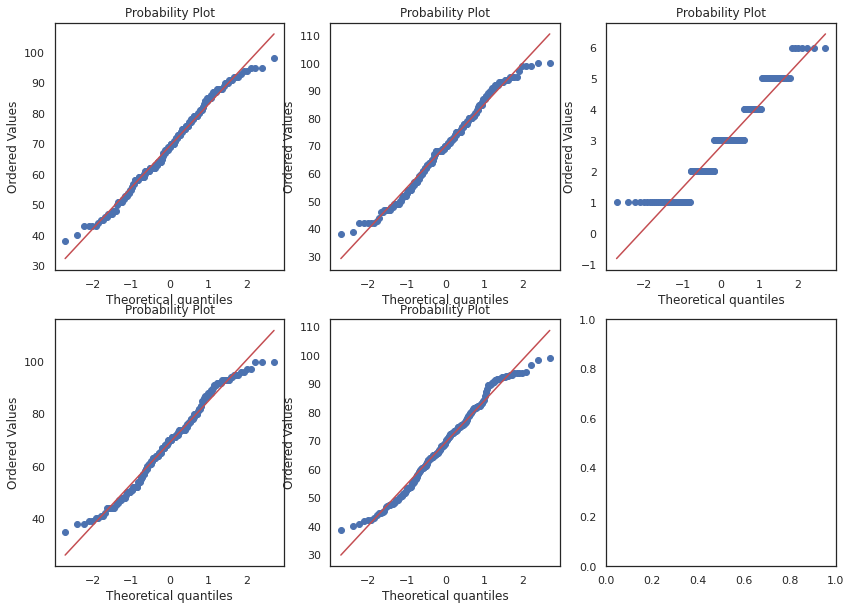

In [ ]:
# Generando qqplot
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

# for i, a in enumerate(cuantitativa):
axs[0, 0].set_title('Math score')
stats.probplot(df['Math score'], plot=axs[0, 0])

axs[0, 1].set_title('Reading Score')
stats.probplot(df['Reading score'], plot=axs[0, 1])

axs[0, 2].set_title('edu_numeric')
stats.probplot(df['edu_numeric'], plot=axs[0, 2])

axs[1, 0].set_title('Writing Score')
stats.probplot(df['Writing score'], plot=axs[1, 0])

axs[1, 1].set_title('Final Score')
stats.probplot(df['Final score'], plot=axs[1, 1])

In [ ]:
# Test de normalidad con shipiro
for a in cuantitativa:
  stat, p = shapiro(df[a])
  #print(a +' - Valor p:', p)
  p=round(p,4)
  if p > 0.05:
      print('Con el p value:', p, ' Los datos de ' + a + ' parecen provenir de una distribución normal')
  else:
      print('Con el p value:', p, ' Los datos de ' + a + ' NO parecen provenir de una distribución normal')

Con el p value: 0.0  Los datos de edu_numeric NO parecen provenir de una distribución normal
Con el p value: 0.0347  Los datos de Math score NO parecen provenir de una distribución normal
Con el p value: 0.0116  Los datos de Reading score NO parecen provenir de una distribución normal
Con el p value: 0.0033  Los datos de Writing score NO parecen provenir de una distribución normal
Con el p value: 0.0055  Los datos de Final score NO parecen provenir de una distribución normal


### Conclusion y Justificacion

* Asumiendo que p tenga que se mayor a 0.05 para validar la hispotesis de que las variables tiene una relacion normal
* A diferencia de lo que se vio al inicio del notebook sobre la distribucion de las variables, ninguna variable cuantitativa parece no venir una distribucion normal

### Estimando parametros

In [ ]:
for a in cuantitativa:
  media = np.mean(df[a])
  desviacion_estandar = np.std(df[a], ddof=1)
  print("Media muestral:", media)
  print("Desviación estándar muestral:", desviacion_estandar)

Media muestral: 2.8115942028985508
Desviación estándar muestral: 1.3858721517286883
Media muestral: 69.20772946859903
Desviación estándar muestral: 13.528837885361744
Media muestral: 69.89855072463769
Desviación estándar muestral: 14.96060677816773
Media muestral: 68.97101449275362
Desviación estándar muestral: 15.843259276417493
Media muestral: 69.35909822866344
Desviación estándar muestral: 14.525927481357202


# 3. Uso de árboles de decisiones

In [ ]:
# Dummisando variables categoricas
dummies = pd.get_dummies(df[['Gender', 'Race/ethnicity', 'Lunch', 'Test preparation course']], drop_first=True)
df_dummizado = pd.concat([df, dummies], axis=1)
df_dummizado = df_dummizado.drop(columns=['Gender', 'Race/ethnicity', 'Lunch', 'Test preparation course'])

In [ ]:
# Eliminando columnas con alta correlacion
df_dummizado = df_dummizado.drop(columns=['Math score', 'Reading score', 'Writing score'], axis=1)

## a) Modelo Decision Tree

### Definir la variable target

* Problema a estudiar, si la informacion que se tiene de los estudiantes influye en su final score
* Se quiere definir el final score con la data optenida

In [ ]:
df_x = df_dummizado.drop(columns = ['Final score'])
df_y = df_dummizado['Final score']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=2023)

### Elegir un metdo para la selecion de variables

In [ ]:
# elegir variables
selector = SequentialFeatureSelector(
    estimator=DecisionTreeRegressor(), n_features_to_select=3,
    cv=5, scoring='r2')
selector.fit(x_train, y_train)

selected_forward = x_train.columns[selector.get_support()]
columnas = selected_forward.sort_values().tolist()
columnas

['Gender_Male', 'Race/ethnicity_Group E', 'Test preparation course_None']

In [ ]:
# Columnas elegidas para probar el modelo
x_train = x_train[columnas]
# Utilizando las columnas para el dataset de test
x_test = x_test[columnas]

In [ ]:
# Entrenar un modelo de DT con las variables seleccionadas
model_dt = DecisionTreeRegressor()
model_dt.fit(x_train, y_train)

# Evaluando prediccion de test y train
y_pred_train = model_dt.predict(x_train)
y_pred_test = model_dt.predict(x_test)

r2_train = r2_score(y_train, y_pred_train)

r2_test = r2_score(y_test, y_pred_test)

print('R2 score train', r2_train)
print('R2 score test', r2_test)

R2 score train 0.5844085727469018
R2 score test 0.28496642868002753


### Representacion grafica DecisionTree

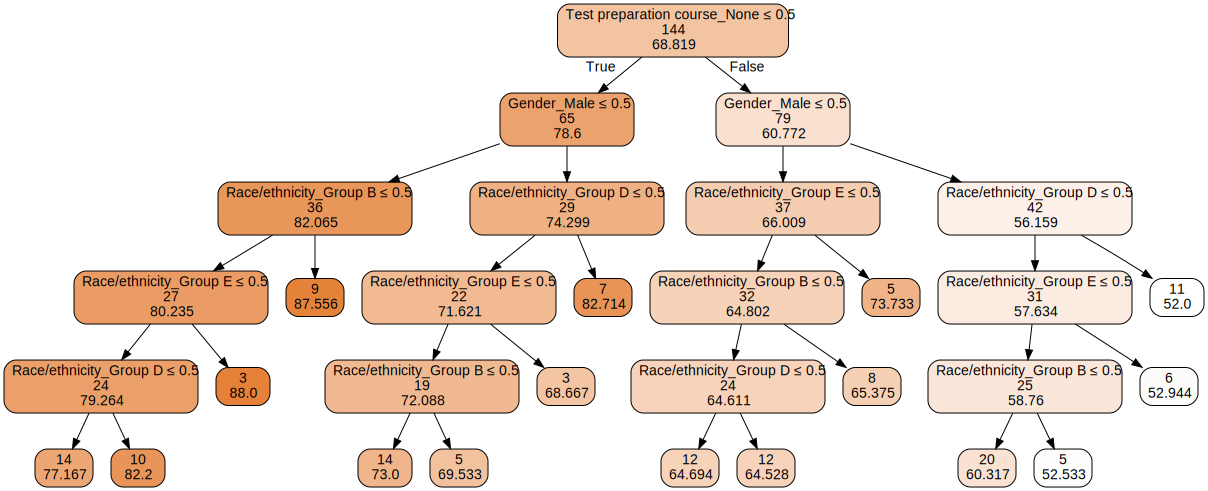

In [ ]:
dot_data = export_graphviz(model_dt, out_file=None,
                           max_depth=5, #cambiar si se necesitan mas ramas
                           feature_names=x_train.columns,
                           class_names=y_train.name,
                           label='Root', impurity=False,
                           filled=True, rounded=True,
                           special_characters=True)

# Crear un objeto graphviz
graph = graphviz.Source(dot_data, format='png')
# Visualizar el árbol de decisión
graph

# 4. Uso de regresión lineal

Problema a estudiar, si la informacion que se tiene de los estudiantes influye en su final score
Se quiere definir el final score con la data optenida

In [ ]:
df_x = df_dummizado.drop(columns = ['Final score'])
df_y = df_dummizado['Final score']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=2023)

### Seleccion de variables

In [ ]:
# elegir variables
selector = SequentialFeatureSelector(
            estimator=LinearRegression(), n_features_to_select=5,
            cv=5, scoring='r2')
selector.fit(x_train, y_train)

selected_forward = x_train.columns[selector.get_support()]
columnas = selected_forward.sort_values().tolist()
columnas

['Gender_Male',
 'Race/ethnicity_Group D',
 'Race/ethnicity_Group E',
 'Test preparation course_None',
 'edu_numeric']

In [ ]:
# Columnas elegidas para probar el modelo
x_train = x_train[columnas]
# Utilizando las columnas para el dataset de test
x_test = x_test[columnas]

In [ ]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)
#


### Significancia del modelo

In [ ]:
model = sm.OLS(y_train, x_train)
results = model.fit()
# Imprimir los valores p para cada variable explicativa
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            Final score   R-squared (uncentered):                   0.885
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              213.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):                    2.08e-63
Time:                        17:48:26   Log-Likelihood:                         -660.95
No. Observations:                 144   AIC:                                      1332.
Df Residuals:                     139   BIC:                                      1347.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

* Valores p bajos indican que la variable explicativa correspondiente es significativa en el modelo, es decir las variables de Gener_male, Mathscore, Reading Score y writing score
* Mientras que valores p altos sugieren que la variable no es significativa como edu_numeric

### Coeficientes del modelo

In [ ]:
coefficients = model_lr.coef_
pd.DataFrame({'Variables': x_train.columns, 'Coeficiente': coefficients}).round(4)

,Variables,Coeficiente
0,Gender_Male,-7.6524
1,Race/ethnicity_Group D,-0.8813
2,Race/ethnicity_Group E,0.5866
3,Test preparation course_None,-14.7128
4,edu_numeric,2.7421


### Multicolinealidad de las variables

In [ ]:
correlaciones = df_dummizado.corr()
vif = pd.DataFrame()
vif["variables"] = df_dummizado.columns
vif["VIF"] = [variance_inflation_factor(df_dummizado.values, i) for i in range(df_dummizado.shape[1])]
print(vif)

                      variables        VIF
0                   Final score  18.553478
1                   edu_numeric   7.095477
2                   Gender_Male   1.956170
3        Race/ethnicity_Group B   3.045082
4        Race/ethnicity_Group C   5.294670
5        Race/ethnicity_Group D   3.834301
6        Race/ethnicity_Group E   2.769288
7                     Lunch_Yes   3.175947
8  Test preparation course_None   2.125448


### Metrica Bonda de ajuste

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R^2:', r2)

MSE: 108.70098226444581
R^2: 0.5377059254734884


# 5. Uso de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Creando el modelo

In [ ]:
# Final score binario: >50 como aprobados
df_dummizado['Final_score_binario'] = df_dummizado['Final score'].apply(lambda x: 1 if x >= 50 else 0)

In [ ]:
# Convertir la variable dependiente en una variable binaria
df_x = df_dummizado.drop(columns = ['Final_score_binario'])
df_y = df_dummizado['Final_score_binario']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=2023)

# Columnas elegidas para probar el modelo
x_train = x_train[columnas]
# Utilizando las columnas para el dataset de test
x_test = x_test[columnas]

# Modelo
model_rl = LogisticRegression()
model_rl.fit(x_train, y_train)
y_pred = model_rl.predict(x_test)

### Coefincientes del modelo

In [ ]:
coefficients = model_rl.coef_.ravel()
pd.DataFrame({'Variables': x_train.columns, 'Coeficiente': coefficients}).round(4)

,Variables,Coeficiente
0,Gender_Male,-0.4358
1,Race/ethnicity_Group E,0.3905
2,Test preparation course_None,-1.8266


### Metrica de bondad de ajuste

In [ ]:

# Evaluar el rendimiento del modelo
print('Precisión:', metrics.accuracy_score(y_test, y_pred))
print('Matriz de confusión:\n', metrics.confusion_matrix(y_test, y_pred))
print('Informe de clasificación:\n', metrics.classification_report(y_test, y_pred))

Precisión: 0.8571428571428571
Matriz de confusión:
 [[ 0  9]
 [ 0 54]]
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.86      1.00      0.92        54

    accuracy                           0.86        63
   macro avg       0.43      0.50      0.46        63
weighted avg       0.73      0.86      0.79        63



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
